In [1]:
import numpy as np

'''
Experimental parameters
'''
alpha = 0.046 * (1 / 1000) # km^-1 (Fiber loss coefficient)
beta = 0.62 # m^-1 (On-chip loss coefficient)
tau_f = 102.85 * (1e-9) # ns (feed-forward time in fiber)
tau_s = 20 * (1e-12) # ps (feed-forward time on chip)
eta_c = 0.99 # chip to fiber coupling efficiency
eta_s = 0.99 # source detector efficient product
c_f = 2e8 # m/s (speed of light in fiber)
c_ch = 7.6e7 # m/s (speed of light in chip)


'''
Derived Parameters
'''
eta_GHZ = eta_s/(2-eta_s)
P_GHZ = (eta_s*(2-eta_s))**3/32
P_chip = np.exp(-beta*tau_s*c_ch)
P_fib = np.exp(-alpha*tau_f*c_f)

In [2]:
k = 7
n = 250
m = 4

P_prime = (eta_GHZ*P_chip**(k+1))**(4*m+1)

In [3]:
def P0(n_GHZ):
    return 1 - (1 - P_GHZ)**n_GHZ

def Ql(l):
    return (eta_GHZ*P_chip**l)**2/2

def Pl(l, n_B, n_GHZ):
    if l == 0:
        return P0(n_GHZ)

    return 1 - (1 - Pl(l-1, n_B, n_GHZ)**2 * Ql(l))**n_B

def P_c1(n_meas, n_B, n_GHZ):
    return 1 - (1 - P_prime * Pl(k, n_B, n_GHZ))**n_meas

def get_n_GHZ(Ns, n_meas, n_B):
    return Ns/(6*n_meas*(2*n_B)**k)

$$P_{c1} = 1 - (1-P_kP')^{n_\text{meas}}$$
but paper has typo that says
$$P_{c1} = 1- (Q_kP')^{n_\text{meas}}$$

In [4]:
def get_P_c1_from_Ns(Ns):
    n_meas_list = np.linspace(1, 50, 50)
    n_B_list = np.linspace(1, 50, 50)

    optimal_P_c1 = -1
    optimal_n_meas = -1
    optimal_n_B = -1
    optimal_n_GHZ = -1

    for n_meas in n_meas_list:
        for n_B in n_B_list:
            n_GHZ = int(get_n_GHZ(Ns, n_meas, n_B))
            if n_GHZ < 1:
                continue
            P_c1_current = P_c1(n_meas, n_B, n_GHZ)
            if P_c1_current > optimal_P_c1:
                optimal_P_c1 = P_c1_current
                optimal_n_meas = n_meas
                optimal_n_B = n_B
                optimal_n_GHZ = n_GHZ

    return optimal_P_c1, optimal_n_meas, optimal_n_B, optimal_n_GHZ

def get_P_cn_from_Ns(Ns):
    return get_P_c1_from_Ns(Ns)[0]**n

([<matplotlib.axis.XTick at 0x236cac2f750>,
 [Text(1000000, 0, '$\\mathdefault{10^{6}}$'),
  Text(100000000, 0, '$\\mathdefault{10^{8}}$'),
  Text(10000000000, 0, '$\\mathdefault{10^{10}}$'),
  Text(1000000000000, 0, '$\\mathdefault{10^{12}}$')])

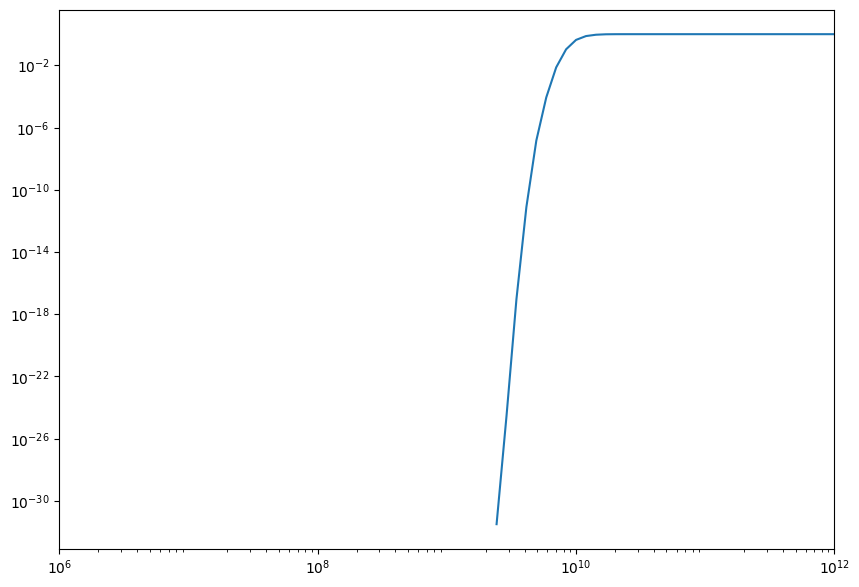

In [5]:
import matplotlib.pyplot as plt

N_s_list = np.logspace(9, 12, 40)
P_cn_list = [get_P_cn_from_Ns(i) for i in N_s_list]

cutoff_index = next((i for i, value in enumerate(P_cn_list) if value > 1e-30)) - 1

N_s_list = N_s_list[cutoff_index:]
P_cn_list = P_cn_list[cutoff_index:]

# make bigger plot
plt.figure(figsize=(10,7))


plt.xscale("log")
plt.yscale("log")
plt.plot(N_s_list, P_cn_list)

plt.xlim(1e6, 1e12)
# only show tick marks at 10^x where x is even
plt.xticks([10**i for i in range(6, 14, 2)])

# Optimal Version

In [6]:
k = 7
n = 250
m = 4

def pl(l):
    mu_l = eta_GHZ * P_chip**(l+1)
    return mu_l**2 * (0.5*eta_s**2 + 0.25*eta_s**4)

def num_Clm_states(l, Ns, multi_index=[]):
    if l == 0:
        return np.random.binomial(Ns/6, P_GHZ)/(2**k)

    else:
        y1 = int(num_Clm_states(l-1, Ns, multi_index + [1]))
        y2 = int(num_Clm_states(l-1, Ns, multi_index + [2]))
        return np.random.binomial(min(y1, y2), pl(l))

def P_c1_advanced(Ns, total_sims = 5000):
    success = 0

    for i in range(total_sims):
        if num_Clm_states(k, Ns) > 0:
            success += 1

    return success / total_sims

def get_P_cn_from_Ns_advanced(Ns, total_sims = 5000):
    return P_c1_advanced(Ns, total_sims = 5000)**n

In [9]:
import matplotlib.pyplot as plt

N_s_list_advanced = np.logspace(6, 7, 20)
P_cn_list_advanced = []
# for i in N_s_list_advanced:
#     P_cn = get_P_cn_from_Ns_advanced(i)
#     P_cn_list_advanced.append(P_cn)
#     print(i, P_cn)

In [7]:
import multiprocessing

In [10]:
pool = multiprocessing.Pool()
P_cn_list_advanced = pool.map(get_P_cn_from_Ns_advanced, N_s_list_advanced)
pool.close()
pool.join()